In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import pickle
import matplotlib.image as mpimg
import h5py
from PIL import Image
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

Image.MAX_IMAGE_PIXELS = None

# Different plotings 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pathological_df = pd.read_json('/Users/macbookpro/Desktop/Educational/FAU/5th Semester /MT/Code/StructuredData/pathological_data.json')
blood_df = pd.read_json('/Users/macbookpro/Desktop/Educational/FAU/5th Semester /MT/Code/StructuredData/blood_data.json')
clinical_df = pd.read_json('/Users/macbookpro/Desktop/Educational/FAU/5th Semester /MT/Code/StructuredData/clinical_data.json')

colors_hpv = sns.color_palette("Pastel1", 2)
colors_survival = sns.color_palette("Accent", 4)
colors_tumor_site = sns.color_palette("Pastel2", 4)
colors_recurrence = sns.color_palette("Pastel2_r", 2)
colors_grading = sns.color_palette("Pastel2", 5)

def add_labels_on_pie(ax, data, colors, font_size=24):
    wedges, texts, autotexts = ax.pie(data, startangle=90, colors=colors, wedgeprops=dict(width=0.4), 
                                      autopct=lambda p: f'{int(p * sum(data) / 100)}')
    for i, autotext in enumerate(autotexts):
        autotext.set_color('black')
        autotext.set_fontsize(font_size)
        autotext.set_weight('bold')
        autotext.set_position((1.9 * autotext.get_position()[0], 1.9 * autotext.get_position()[1]))

pathological_df['hpv_status'] = pathological_df['hpv_association_p16'].apply(
    lambda x: 'HPV+' if 'positive' in x or 'HPV+' in x else 'HPV-'
)

hpv_counts = pathological_df['hpv_status'].value_counts()
grading_counts = pathological_df['grading_hpv'].value_counts()
recurrence_counts = pathological_df['perinodal_invasion'].fillna('no').value_counts()
survival_counts = clinical_df['survival_status_with_cause'].value_counts()
tumor_site_counts = pathological_df['primary_tumor_site'].value_counts()

fig, axes = plt.subplots(2, 2, figsize=(40, 20), subplot_kw=dict(aspect="equal"))

add_labels_on_pie(axes[0, 0], hpv_counts, colors_hpv, font_size=32)
axes[0, 0].text(0, 0, 'HPV Status', ha='center', va='center', fontsize=32, weight='bold')
axes[0, 0].legend(['HPV-', 'HPV+'], title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=26, title_fontsize=30)

add_labels_on_pie(axes[1, 0], survival_counts, colors_survival, font_size=32)
axes[1, 0].text(0, 0, 'Survival', ha='center', va='center', fontsize=32, weight='bold')
axes[1, 0].legend(['Living', 'Deceased Tumor specific', 'Deceased not Tumor specific', 'Deceased'], title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=26, title_fontsize=30)

add_labels_on_pie(axes[0, 1], tumor_site_counts, colors_tumor_site, font_size=32)
axes[0, 1].text(0, 0, 'Tumor Site', ha='center', va='center', fontsize=32, weight='bold')
axes[0, 1].legend(['Oropharynx', 'Larynx', 'Oral Cavity', 'Hypopharynx'], title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=26, title_fontsize=30)

add_labels_on_pie(axes[1, 1], recurrence_counts, colors_recurrence, font_size=32)
axes[1, 1].text(0, 0, 'Recurrence', ha='center', va='center', fontsize=32, weight='bold')
axes[1, 1].legend(['Recurred', 'Not Recurred'], title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=26, title_fontsize=30)

plt.tight_layout()
plt.savefig('/Users/macbookpro/Downloads/pie.png', dpi=300, bbox_inches='tight')
plt.show()


# Additional data 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


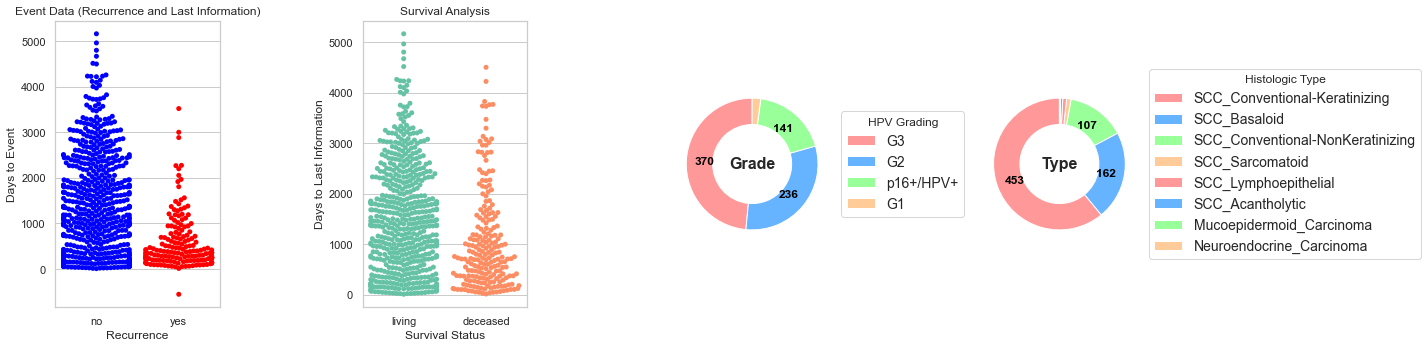

In [91]:
clinical_data['recurrence'].fillna('None', inplace=True)

clinical_data['days_to_event'] = clinical_data.apply(
    lambda row: row['days_to_recurrence'] if row['recurrence'] == 'yes' else row['days_to_last_information'],
    axis=1
)

event_data = clinical_data[['patient_id', 'recurrence', 'days_to_event']]
survival_data = clinical_data[['patient_id', 'survival_status', 'days_to_last_information']]

palette = {'yes': 'red', 'no': 'blue', 'None': 'green'}

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.swarmplot(data=event_data, x='recurrence', y='days_to_event', palette=palette, ax=axes[0])
axes[0].set_title('Event Data (Recurrence and Last Information)')
axes[0].set_xlabel('Recurrence')
axes[0].set_ylabel('Days to Event')

sns.swarmplot(data=survival_data, x='survival_status', y='days_to_last_information', palette='Set2', ax=axes[1])
axes[1].set_title('Survival Analysis')
axes[1].set_xlabel('Survival Status')
axes[1].set_ylabel('Days to Last Information')

def add_labels_on_pie(ax, data, colors):
    def autopct(pct):
        total = sum(data)
        val = int(round(pct * total / 100.0))
        return f'{val}' if val > total * 0.05 else ''
    wedges, texts, autotexts = ax.pie(data, startangle=90, colors=colors, wedgeprops=dict(width=0.4), autopct=autopct)
    for i, autotext in enumerate(autotexts):
        autotext.set_color('black')
        autotext.set_fontsize(12)
        autotext.set_weight('bold')
        autotext.set_ha('center')
        autotext.set_va('center')
        autotext.set_position((1.2 * autotext.get_position()[0], 1.2 * autotext.get_position()[1]))

colors_hpv = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
grade_counts = pathological_df['grading_hpv'].value_counts()
add_labels_on_pie(axes[2], grade_counts, colors_hpv)
axes[2].text(0, 0, 'Grade', ha='center', va='center', fontsize=16, weight='bold')

grading_hpv_labels = grade_counts.index.tolist()
axes[2].legend(grading_hpv_labels, title="HPV Grading", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

colors_survival = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
histologic_type_counts = pathological_df['histologic_type'].value_counts()
add_labels_on_pie(axes[3], histologic_type_counts, colors_survival)
axes[3].text(0, 0, 'Type', ha='center', va='center', fontsize=16, weight='bold')

histologic_type_labels = histologic_type_counts.index.tolist()
axes[3].legend(histologic_type_labels, title="Histologic Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.tight_layout()
plt.show()


In [81]:
pathological_df.head()

,patient_id,primary_tumor_site,pT_stage,pN_stage,grading_hpv,hpv_association_p16,number_of_positive_lymph_nodes,number_of_resected_lymph_nodes,perinodal_invasion,lymphovascular_invasion_L,vascular_invasion_V,perineural_invasion_Pn,resection_status,resection_status_carcinoma_in_situ,carcinoma_in_situ,closest_resection_margin_in_cm,histologic_type,infiltration_depth_in_mm
0,1,Hypopharynx,pT4a,pN2b,G3,Not_tested/No_OSCC,3.0,61,yes,1,0,0,R0,CIS Absent,Absent,<0.1,SCC_Basaloid,19.0
1,2,Larynx,pT2,pN2c,G3,Not_tested/No_OSCC,3.0,48,yes,1,0,0,R0,CIS Absent,Absent,None,SCC_Conventional-Keratinizing,9.0
2,3,Oropharynx,pT1,pN1,p16+/HPV+,positive,1.0,15,no,0,0,0,R0,CIS Absent,Absent,0.5,SCC_Basaloid,7.0
3,4,Oral_Cavity,pT2,pN0,G2,Not_tested/No_OSCC,0.0,13,None,0,0,0,R0,Ris0,CIS,0.3,SCC_Conventional-Keratinizing,8.0
4,5,Oropharynx,pT1,NX,p16+/HPV+,positive,NaN,0,None,0,0,0,R0,Ris0,CIS,0.5,SCC_Conventional-Keratinizing,3.0


# AUC dist. conparison

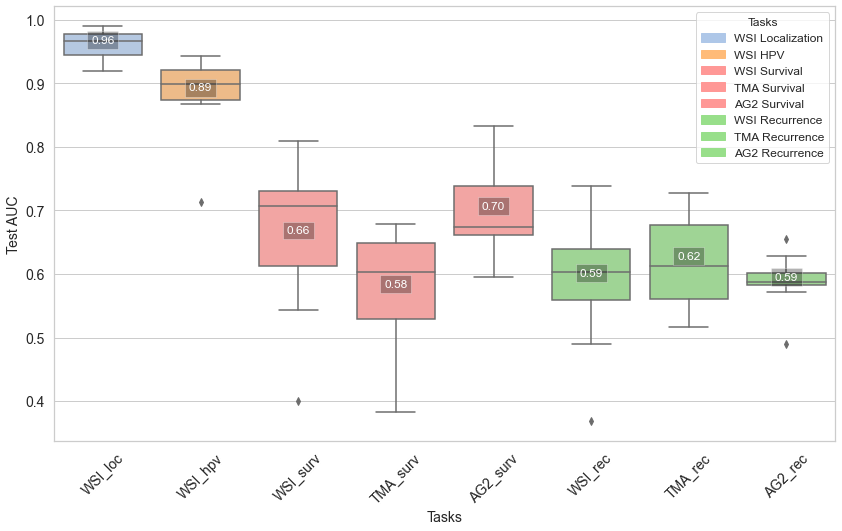

In [23]:
summary_AG2_surv = pd.read_csv('/Users/macbookpro/Downloads/summary_surv_ag2.csv')
summary_ag2_rec = pd.read_csv('/Users/macbookpro/Downloads/summary_rec_ag2.csv')
summary_tma_rec = pd.read_csv('/Users/macbookpro/Downloads/summary_rec_tma.csv')
summary_wsi_rec = pd.read_csv('/Users/macbookpro/Downloads/summary_rec_wsi.csv')
summary_wsi_loc = pd.read_csv('/Users/macbookpro/Downloads/summary_loc.csv')
summary_wsi_hpv = pd.read_csv('/Users/macbookpro/Downloads/summary_hpv.csv')
summary_wsi_surv = pd.read_csv('/Users/macbookpro/Downloads/summary_surv_wsi.csv')
summary_tma_surv = pd.read_csv('/Users/macbookpro/Downloads/summary_surv_tma.csv')

def plot_combined_auc_comparison(datasets, labels, title, custom_legend):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 8))

    palette = {
        'WSI_loc': '#aec7e8',
        'WSI_hpv': '#ffbb78',
        'WSI_surv': '#ff9896',
        'TMA_surv': '#ff9896',
        'AG2_surv': '#ff9896',
        'WSI_rec': '#98df8a',
        'TMA_rec': '#98df8a',
        'AG2_rec': '#98df8a'
    }

    combined_data = pd.concat([
        pd.DataFrame({'test_auc': dataset['test_auc'], 'model': label})
        for dataset, label in zip(datasets, labels)
    ])

    sns.boxplot(x='model', y='test_auc', data=combined_data, palette=[palette[label] for label in labels], ax=ax, fliersize=5)

    for i, label in enumerate(labels):
        mean_value = combined_data[combined_data['model'] == label]['test_auc'].mean()
        ax.text(i, mean_value, f'{mean_value:.2f}', 
                horizontalalignment='center', color='white', fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='black', alpha=0.3))

    ax.set_xlabel('Tasks', fontsize=14)
    ax.set_ylabel('Test AUC', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    custom_handles = [mpatches.Patch(color=palette[label], label=custom_legend[label]) for label in labels]
    ax.legend(handles=custom_handles, title='Tasks', loc='upper right', fontsize=12)

    plt.savefig("/Users/macbookpro/Downloads/all_tesks_auc", dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

datasets = [summary_wsi_loc, summary_wsi_hpv, summary_wsi_surv, summary_tma_surv, summary_AG2_surv, summary_wsi_rec, summary_tma_rec, summary_ag2_rec]
labels = ['WSI_loc', 'WSI_hpv', 'WSI_surv', 'TMA_surv', 'AG2_surv', 'WSI_rec', 'TMA_rec', 'AG2_rec']

custom_legend = {
    'WSI_loc': 'WSI Localization',
    'WSI_hpv': 'WSI HPV',
    'WSI_surv': 'WSI Survival',
    'TMA_surv': 'TMA Survival',
    'AG2_surv': 'AG2 Survival',
    'WSI_rec': 'WSI Recurrence',
    'TMA_rec': 'TMA Recurrence',
    'AG2_rec': 'AG2 Recurrence'
}

plot_combined_auc_comparison(datasets, labels, 'Test AUC Distribution', custom_legend)


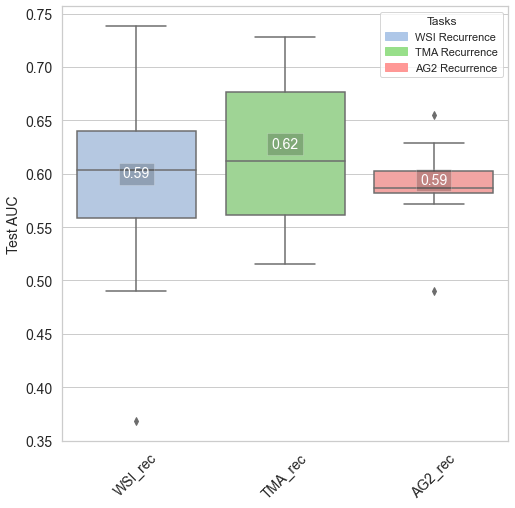

In [48]:
datasets = [summary_wsi_rec, summary_tma_rec, summary_ag2_rec]
labels = ['WSI_rec', 'TMA_rec', 'AG2_rec']

custom_legend = {
    'WSI_rec': 'WSI Recurrence',
    'TMA_rec': 'TMA Recurrence',
    'AG2_rec': 'AG2 Recurrence'
}

plot_combined_auc_comparison(datasets, labels, 'Test AUC Distribution', custom_legend)


# Groupping results from the heatmmap.py


Filtered filenames:
0_PrimaryTumor_HE_684_x_79280_y_39264_a_100.000.png
10_PrimaryTumor_HE_684_x_80304_y_39264_a_99.964.png
11_PrimaryTumor_HE_684_x_81840_y_38496_a_99.961.png
12_PrimaryTumor_HE_684_x_47536_y_51552_a_99.957.png
13_PrimaryTumor_HE_684_x_44976_y_39264_a_99.954.png
14_PrimaryTumor_HE_684_x_81584_y_39520_a_99.950.png
1_PrimaryTumor_HE_684_x_44976_y_41312_a_99.996.png
2_PrimaryTumor_HE_684_x_48816_y_39520_a_99.993.png
3_PrimaryTumor_HE_684_x_79536_y_39008_a_99.989.png
4_PrimaryTumor_HE_684_x_49328_y_39776_a_99.986.png
5_PrimaryTumor_HE_684_x_48560_y_39264_a_99.982.png
6_PrimaryTumor_HE_684_x_40624_y_56672_a_99.979.png
7_PrimaryTumor_HE_684_x_79024_y_39264_a_99.975.png
8_PrimaryTumor_HE_684_x_50352_y_47712_a_99.971.png
9_PrimaryTumor_HE_684_x_78000_y_43104_a_99.968.png


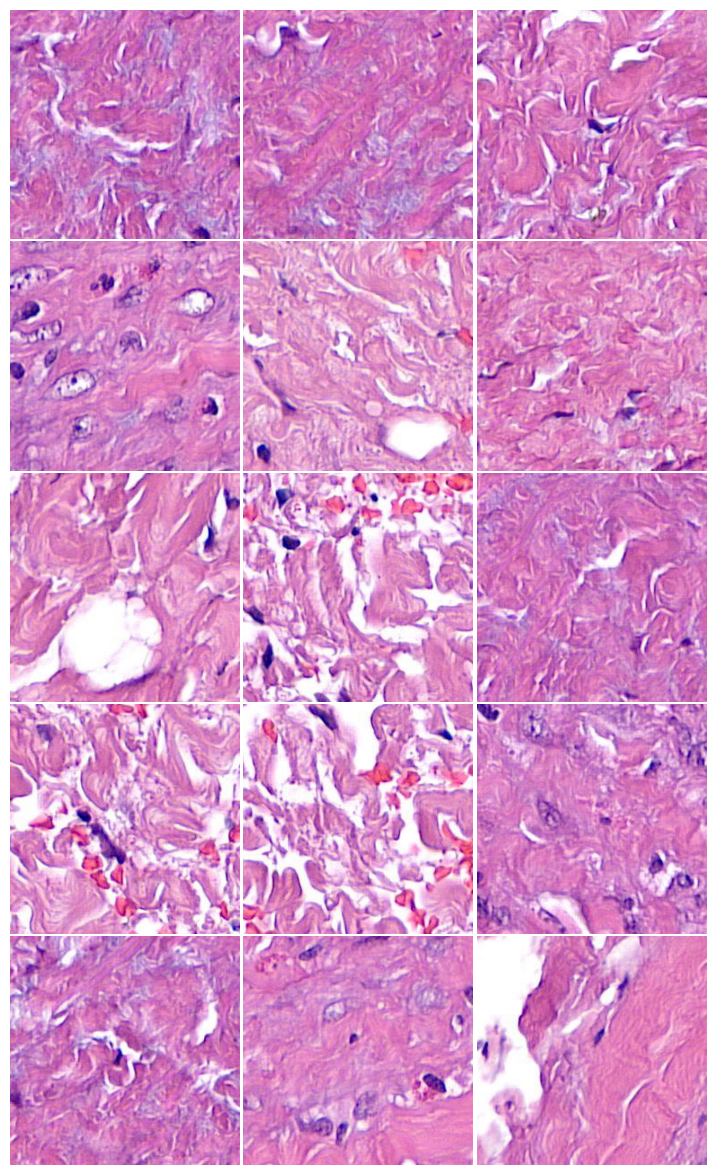

In [2]:

directory = '/data/ve59kedo/thesis/CLAM_UNI/heatmaps/heatmap_production_results/Final_LOC_heatmap/sampled_patches/label_Larynx_pred_1/topk_high_attention'
specific_id = '684'

image_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))])
filtered_image_files = [f for f in image_files if f'HE_{specific_id}_' in os.path.basename(f)]

print("\nFiltered filenames:")
for f in filtered_image_files:
    print(os.path.basename(f))

if len(filtered_image_files) != 15:
    raise ValueError(f"There should be exactly 45 image files with ID {specific_id}, but found {len(filtered_image_files)}")

fig, axes = plt.subplots(5, 3, figsize=(9, 15))

for idx, ax in enumerate(axes.flat):
    img = mpimg.imread(filtered_image_files[idx])
    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(f'/data/ve59kedo/thesis/Larynx_pred_1_{specific_id}', bbox_inches='tight', pad_inches=0)
plt.show()


# plotting one of the patches using the h5 coordinates

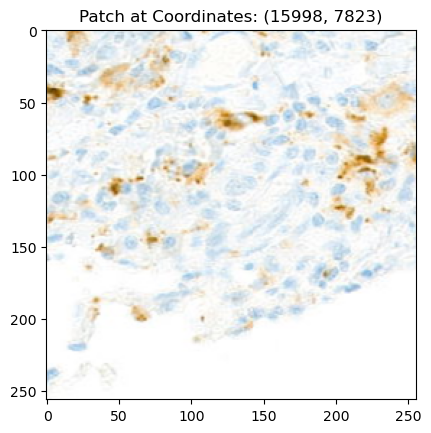

In [12]:


h5_path = '/data_slow2/ve59kedo/UNI_DSTMA_feat2_256/h5_files/DSTMA_001.h5'
tiff_path = '/data_slow2/ve59kedo/TMA/TMA_ordered/DSTMA_patient_001.tiff'

with h5py.File(h5_path, 'r') as file:
    coords = file['coords'][100]  
    patch_level = 0
    patch_size = 256

x, y = coords

wsi_image = Image.open(tiff_path)
patch = wsi_image.crop((x, y, x + patch_size, y + patch_size))

plt.imshow(patch)
plt.title(f'Patch at Coordinates: ({x}, {y})')
plt.show()


In [29]:
# same as above but for WSI

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

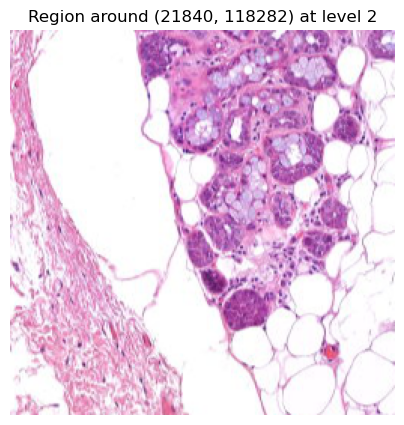

In [17]:
import openslide
from matplotlib import pyplot as plt
import h5py

image_path = '/data_slow/ve59kedo/wsi/PrimaryTumor_HE_001.svs'
coords_path = '/data_slow2/ve59kedo/EffiNetB0_feat_256/h5_files/PrimaryTumor_HE_001.h5'

with h5py.File(coords_path, 'r') as h5_file:
    coords = h5_file['coords'][:]
    
selected_coord = coords[100]
x, y = selected_coord

size = 256

slide = openslide.OpenSlide(image_path)
level = 2

start_x = x - size // 2
start_y = y - size // 2

region = slide.read_region((start_x, start_y), level, (size, size))
region = region.convert("RGB")

plt.figure(figsize=(5, 5))
plt.imshow(region)
plt.title(f'Region around ({x}, {y}) at level {level}')
plt.axis('off')
plt.show()


# For each thereshold used in WSI and TMA ROC curves along with the average 

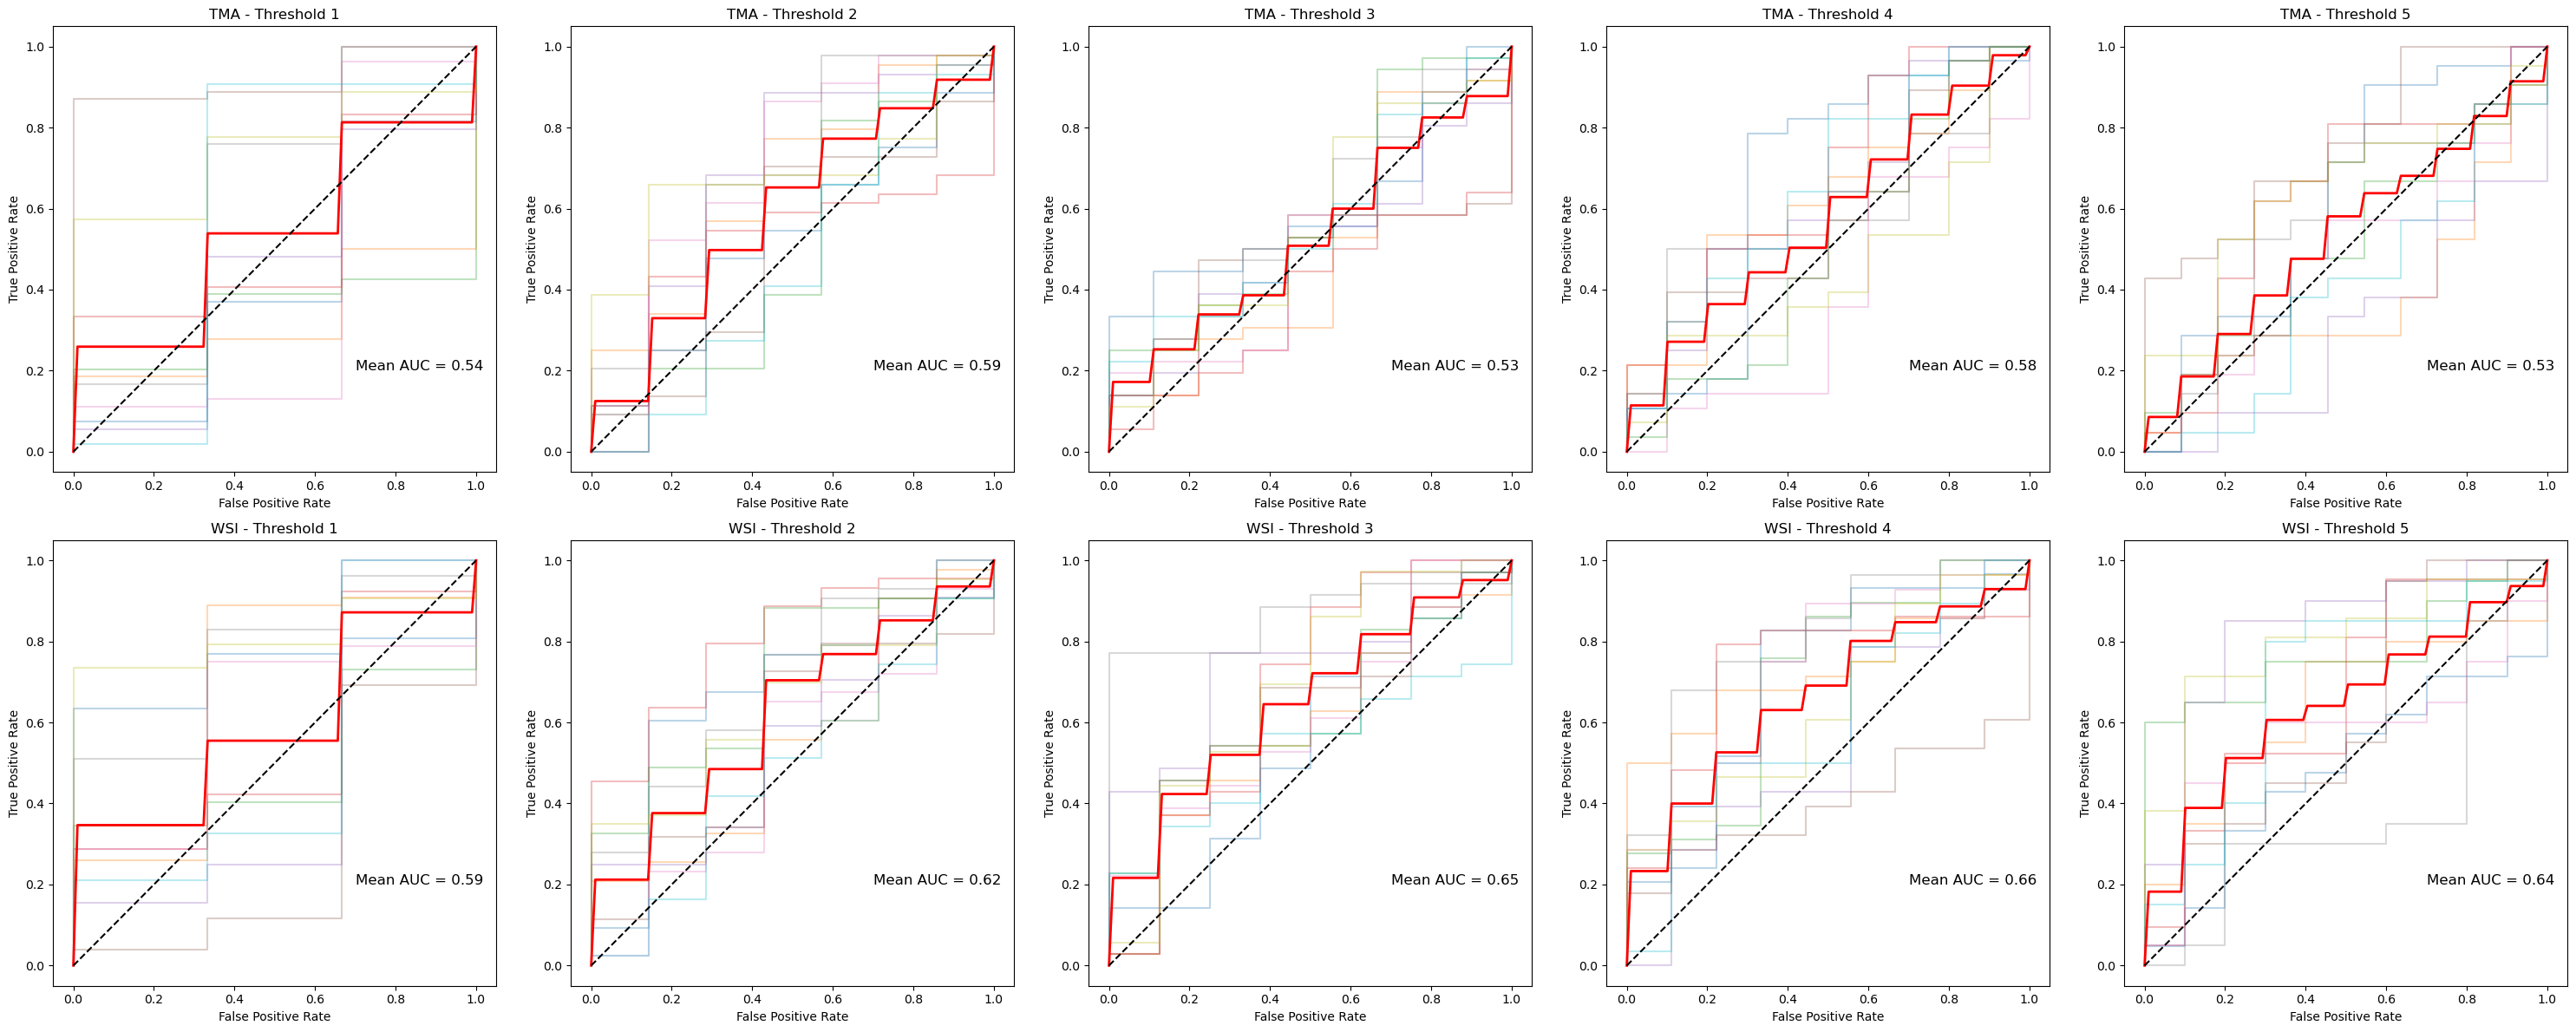

In [25]:

base_paths = [
    '/data/ve59kedo/thesis/results_2/UNI_surv_tma_2class/',
    '/data/ve59kedo/thesis/results_2/UNI_surv_wsi_2class/'
]

base_path_labels = ['TMA', 'WSI']

experiments = [
    'exp_th1_sampled_1_s1',
    'exp_th2_sampled_1_s1',
    'exp_th3_sampled_1_s1',
    'exp_th4_sampled_1_s1',
    'exp_th5_sampled_1_s1'
]

def load_and_compute_auc(exp_path):
    summary_df = pd.read_csv(f'{exp_path}/summary.csv')
    true_labels_list, probs_list, auc_scores = [], [], []

    for i in range(10):
        with open(f'{exp_path}/split_{i}_results.pkl', 'rb') as file:
            data = pickle.load(file)

        true_labels = [value['label'] for value in data.values()]
        probs = [value['prob'][0][1] for value in data.values()]

        fpr, tpr, thresholds = roc_curve(true_labels, probs)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        true_labels_list.append(true_labels)
        probs_list.append(probs)

    return true_labels_list, probs_list, auc_scores

def plot_roc_curves(ax, true_labels_list, probs_list, auc_scores, title):
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    for i, (true_labels, probs) in enumerate(zip(true_labels_list, probs_list)):
        fpr, tpr, thresholds = roc_curve(true_labels, probs)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tpr_list.append(tpr_interp)
        ax.plot(fpr, tpr, alpha=0.3)

    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='red', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.text(0.7, 0.2, f'Mean AUC = {mean_auc:.2f}', fontsize=12)

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for path_idx, (base_path, base_path_label) in enumerate(zip(base_paths, base_path_labels)):
    for exp_idx, exp in enumerate(experiments):
        ax_idx = path_idx * 5 + exp_idx
        exp_path = f'{base_path}{exp}'
        true_labels_list, probs_list, auc_scores = load_and_compute_auc(exp_path)
        title = f'{base_path_label} - Threshold {exp.split("_")[1][2]}'
        plot_roc_curves(axes[ax_idx], true_labels_list, probs_list, auc_scores, title)

plt.tight_layout()
plt.savefig("/data/ve59kedo/thesis/results_2/ROC_SURV.png", dpi=300)
plt.show()


# Confusion matrix for each fold 

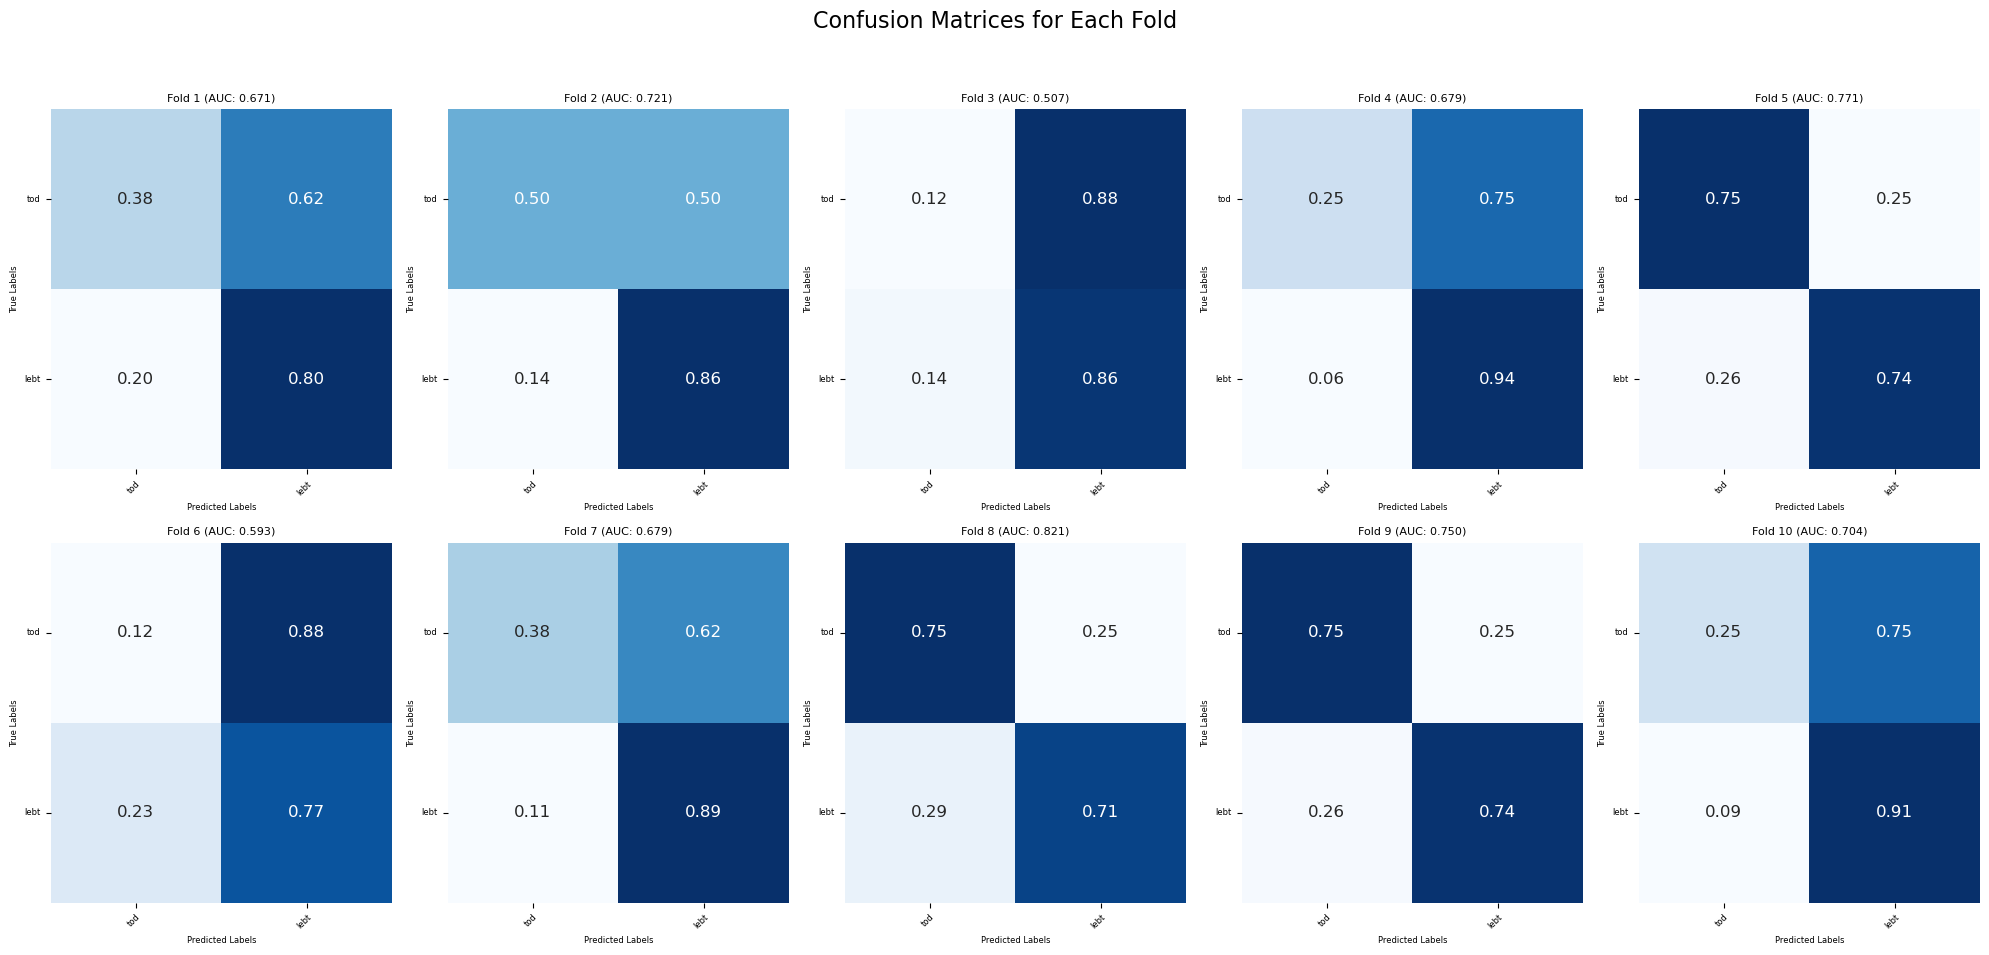

In [28]:


summary_file_path = '/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th3_sampled_2_s1/summary.csv'
summary_df = pd.read_csv(summary_file_path)

cms = []

for i in range(10):
    file_path = f'/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th3_sampled_2_s1/split_{i}_results.pkl'
    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    true_labels = []
    predictions = []

    for key, value in data.items():
        true_label = value['label']
        probabilities = value['prob'][0]
        predicted_label = np.argmax(probabilities)
        true_labels.append(true_label)
        predictions.append(predicted_label)

    cm = confusion_matrix(true_labels, predictions)
    cms.append(cm)

def plot_confusion_matrices(cms, auc_values, classes, normalize=True, cmap=plt.cm.Blues):
    num_folds = len(cms)
    num_rows = 2
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle('Confusion Matrices for Each Fold', fontsize=16)

    for i, (ax, auc) in enumerate(zip(axes.flat, auc_values)):
        if i < num_folds:
            cm = cms[i]
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, ax=ax, cbar=False, annot_kws={"fontsize":12})
            ax.set_title(f'Fold {i+1} (AUC: {auc:.3f})', fontsize=8)
            ax.set_xlabel('Predicted Labels', fontsize=6)
            ax.set_ylabel('True Labels', fontsize=6)
            ax.set_xticklabels(classes)
            ax.set_yticklabels(classes)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
            plt.setp(ax.get_yticklabels(), rotation=0, fontsize=6)
        else:
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

auc_values = summary_df.set_index('folds')['test_auc'].tolist()

plot_confusion_matrices(cms, auc_values, classes=['tod', 'lebt'])
